In [1]:
#hide
#skip
%config Completer.use_jedi = False
%config IPCompleter.greedy=True
# upgrade fastrl on colab
! [ -e /content ] && pip install -Uqq fastrl['dev'] pyvirtualdisplay && \
                     apt-get install -y xvfb python-opengl > /dev/null 2>&1 
# NOTE: IF YOU SEE VERSION ERRORS, IT IS SAFE TO IGNORE THEM. COLAB IS BEHIND IN SOME OF THE PACKAGE VERSIONS

In [2]:
# hide
from fastcore.imports import in_colab
# Since colab still requires tornado<6, we don't want to import nbdev if we don't have to
if not in_colab():
    from nbdev.showdoc import *
    from nbdev.imports import *
    if not os.environ.get("IN_TEST", None):
        assert IN_NOTEBOOK
        assert not IN_COLAB
        assert IN_IPYTHON
else:
    # Virutual display is needed for colab
    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(400, 300))
    display.start()

In [3]:
# default_exp fastai.data.load

In [4]:
# export
# Python native modules
import os
from typing import Callable
# Third party libs
from fastcore.all import *
import torchdata.datapipes as dp
from torch.utils.data.dataloader_experimental import DataLoader2
from torch.utils.data.graph import traverse
# Local modules
from fastrl.fastai.data.pipes.core import *

from fastrl.fastai.data.pipes.map.mux import *
from fastrl.fastai.data.pipes.map.demux import *

# Loading
> Objects using the `Loop` and `DataPipe` API for DataLoading

We will replicate [fastai mnist loading](https://colab.research.google.com/github/fastai/fastbook/blob/master/04_mnist_basics.ipynb).

In [5]:
from fastai.vision.all import get_image_files,PILImage,ToTensor,PILBase,untar_data,URLs,get_image_files

path = untar_data(URLs.MNIST_SAMPLE)

(path/'train').ls()

(#2) [Path('/home/fastrl_user/.fastai/data/mnist_sample/train/7'),Path('/home/fastrl_user/.fastai/data/mnist_sample/train/3')]

First we create the dataset...

In [6]:
# export
class TypeTransformLoop(dp.map.MapDataPipe):
    def __init__(self,datapipe, type_tfms):
        self.type_tfms,self.datapipe = Pipeline(type_tfms),datapipe
    
    def __getitem__(self, index):
        data = self.datapipe[index]
        return self.type_tfms(data)
            
    def __len__(self): return len(self.datapipe)
    
class ItemTransformLoop(dp.iter.IterDataPipe):
    def __init__(self,source_datapipe, item_tfms:List[Callable]): 
        self.item_tfms,self.source_datapipe = Pipeline(item_tfms),source_datapipe
    
    def __iter__(self):
        for data in self.source_datapipe:
            yield self.item_tfms(data)
    
class BatchTransformLoop(dp.iter.IterDataPipe):
    def __init__(self,source_datapipe, batch_tfms):
        self.batch_tfms,self.source_datapipe = Pipeline(batch_tfms),source_datapipe
    
    def __iter__(self):
        for data in self.source_datapipe:
            yield self.batch_tfms(data)

In [7]:
# export
def default_loader_loop(
    items:Iterable,
    splitter:Callable,
    cbs:Optional[List[Callback]]=None,
    type_tfms:Optional[Transform]=None,
    item_tfms:Optional[Transform]=None,
    batch_tfms:Optional[Transform]=None,
    bs:int=2,
    shuffler:Optional[Union[dp.iter.IterDataPipe,dp.map.MapDataPipe]]=None
):
    pipe = dp.map.SequenceWrapper(items).add_cbs(cbs)
    train_vals = DemultiplexerMapDataPipe(
        pipe,
        num_instances=2,
        classifier_fn=splitter,
        drop_none=True
    )
    train_vals = L(train_vals).map(Self.add_cbs(cbs))
    train_vals = L(train_vals).map(TypeTransformLoop,type_tfms=ifnone(type_tfms,L()))
    train_vals = L(train_vals).map(Self.add_cbs(cbs))
    if shuffler:
        train_vals = train_vals.map(shuffler)
    else:
        train_vals = train_vals.map(Self.shuffle())
    train_vals = L(train_vals).map(Self.add_cbs(cbs))
    train_vals = train_vals.map(dp.iter.MapToIterConverter)
    train_vals = L(train_vals).map(Self.add_cbs(cbs))
    train_vals = L(train_vals).map(dp.iter.ShardingFilter).map(Self.add_cbs(cbs))
    train_vals = train_vals.map(ItemTransformLoop, item_tfms=ifnone(item_tfms,L()))
    train_vals = L(train_vals).map(Self.add_cbs(cbs))
    train_vals = train_vals.map(Self.batch(batch_size=bs))
    train_vals = L(train_vals).map(Self.add_cbs(cbs))
    
    return train_vals

In [8]:
# export
def default_loader_loop(
    items:Iterable,
    splitter:Callable,
    cbs:Optional[List[Callback]]=None,
    type_tfms:Optional[Transform]=None,
    item_tfms:Optional[Transform]=None,
    batch_tfms:Optional[Transform]=None,
    bs:int=2,
    shuffler:Optional[Union[dp.iter.IterDataPipe,dp.map.MapDataPipe]]=None
):
    pipe = dp.map.SequenceWrapper(items) #.add_cbs(cbs)
    train_vals = DemultiplexerMapDataPipe(
        pipe,
        num_instances=2,
        classifier_fn=splitter,
        drop_none=True
    )
    # train_vals = L(train_vals).map(Self.add_cbs(cbs))
    train_vals = L(train_vals).map(TypeTransformLoop,type_tfms=ifnone(type_tfms,L()))
    # train_vals = L(train_vals).map(Self.add_cbs(cbs))
    if shuffler:
        train_vals = train_vals.map(shuffler)
    else:
        train_vals = train_vals.map(Self.shuffle())
    # train_vals = L(train_vals).map(Self.add_cbs(cbs))
    train_vals = train_vals.map(dp.iter.MapToIterConverter)
    # train_vals = L(train_vals).map(Self.add_cbs(cbs))
    train_vals = L(train_vals).map(dp.iter.ShardingFilter) #.map(Self.add_cbs(cbs))
    train_vals = train_vals.map(ItemTransformLoop, item_tfms=ifnone(item_tfms,L()))
    train_vals = train_vals.map(Self.batch(batch_size=bs))
    # for _pipe in reversed(find_pipes(dp.iter.Zipper(*train_vals),lambda o:True)): pipe = _pipe.add_cbs_before(cbs)
    # for _pipe in reversed(find_pipes(dp.iter.Zipper(*train_vals),lambda o:True)): pipe = _pipe.add_cbs_after(cbs)
    
    pipe = add_cbs_to_pipes(dp.iter.Zipper(*train_vals),cbs)
    
    return pipe.datapipes

In [9]:
class SayHi(dp.iter.IterDataPipe):
    def __init__(self,source_datapipe): self.source_datapipe = source_datapipe
    def __iter__(self):
        for o in self.source_datapipe: 
            print(f'Hi! From {self.source_datapipe} {id(self.source_datapipe)}')
            yield o

class SayBye(dp.iter.IterDataPipe):
    def __init__(self,source_datapipe): self.source_datapipe = source_datapipe
    def __iter__(self):
        for o in self.source_datapipe: 
            print(f'SayBye! From {self.source_datapipe} {id(self.source_datapipe)}')
            yield o
        
class TestCallback(Callback):
    
    def not_a_hook(self): return 'this should not be processed as a hook!'
    
    def add_one(self,before=ItemTransformLoop,after=None,not_under=None) -> List[dp.iter.IterDataPipe]:
        return L(SayHi)
    def add_point_zero_five(self,before=None,after=dp.iter.Batcher,not_under=None) -> List[dp.iter.IterDataPipe]:
        return L(SayBye)

In [10]:
# export
def GrandparentSplitter(train='train',valid='valid'):
    def splitter(item):
        if all(s not in item.parts for s in (train,valid)): return None
        if item.is_dir(): return None
        # valid=1, train=0
        return valid in item.parts 
    return splitter

In [11]:
base = default_loader_loop(
    L(path.rglob('*')),
    GrandparentSplitter(),
    type_tfms = L(PILImage.create,ToTensor),
    cbs = L(TestCallback())
)

In [12]:

from fastrl.fastai.data.pipes.map.demux import _DemultiplexerMapDataPipe

In [13]:

from torch.utils.data.graph import traverse
traverse(base[0])

{BatcherIterDataPipe: {ItemTransformLoop: {SayHi: {ShardingFilterIterDataPipe: {MapToIterConverterIterDataPipe: {ShufflerMapDataPipe: {TypeTransformLoop: {_DemultiplexerChildMapDataPipe: {SequenceWrapperMapDataPipe: {}}}}}}}}}}

In [14]:
train_dl,valid_dl = DataLoader2(base[0],num_workers=0,batch_size=2),DataLoader2(base[1])

In [15]:
from torchdata.datapipes.utils import to_graph

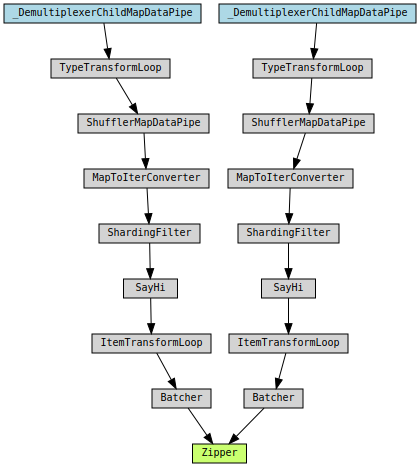

In [16]:
to_graph(dp.iter.Zipper(*base))

In [17]:
mod = 0 #len(L(path.rglob('*')))//10
for i,element in enumerate(train_dl):
    # if i%mod==0: print(L(element).map(Self.shape()), f'x{i}')
    print(L(element).map(Self.shape()), f'x{i}')
    if i>3: break

Hi! From ShardingFilterIterDataPipe 139730513349072
Hi! From ShardingFilterIterDataPipe 139730513349072
Hi! From ShardingFilterIterDataPipe 139730513349072
Hi! From ShardingFilterIterDataPipe 139730513349072
[torch.Size([2, 3, 28, 28]), torch.Size([2, 3, 28, 28])] x0
Hi! From ShardingFilterIterDataPipe 139730513349072
Hi! From ShardingFilterIterDataPipe 139730513349072
Hi! From ShardingFilterIterDataPipe 139730513349072
Hi! From ShardingFilterIterDataPipe 139730513349072
[torch.Size([2, 3, 28, 28]), torch.Size([2, 3, 28, 28])] x1
Hi! From ShardingFilterIterDataPipe 139730513349072
Hi! From ShardingFilterIterDataPipe 139730513349072
Hi! From ShardingFilterIterDataPipe 139730513349072
Hi! From ShardingFilterIterDataPipe 139730513349072
[torch.Size([2, 3, 28, 28]), torch.Size([2, 3, 28, 28])] x2
Hi! From ShardingFilterIterDataPipe 139730513349072
Hi! From ShardingFilterIterDataPipe 139730513349072
Hi! From ShardingFilterIterDataPipe 139730513349072
Hi! From ShardingFilterIterDataPipe 1397

In [18]:
# hide
from fastcore.imports import in_colab

# Since colab still requires tornado<6, we don't want to import nbdev if we don't have to
if not in_colab():
    from nbdev.export import *
    from nbdev.export2html import *
    from nbdev.cli import *
    make_readme()
    notebook2script(silent=True)

converting /home/fastrl_user/fastrl/nbs/index.ipynb to README.md
